In [1]:
print("Welcome to my EMR Notebook!")

VBox()

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,Current session?
0,application_1597523960888_0001,pyspark,idle,Link,Link,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Welcome to my EMR Notebook!

In [2]:
%%info

ID,YARN Application ID,Kind,State,Spark UI,Driver log,Current session?
0,application_1597523960888_0001,pyspark,idle,Link,Link,✔


In [3]:
sc.list_packages()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Package                    Version
-------------------------- -------
beautifulsoup4             4.9.0  
boto                       2.49.0 
jmespath                   0.9.5  
lxml                       4.5.0  
mysqlclient                1.4.2  
nltk                       3.4.5  
nose                       1.3.4  
numpy                      1.16.5 
pip                        9.0.1  
py-dateutil                2.2    
python37-sagemaker-pyspark 1.3.0  
pytz                       2019.3 
PyYAML                     5.3.1  
setuptools                 28.8.0 
six                        1.13.0 
soupsieve                  1.9.5  
wheel                      0.29.0 
windmill                   1.6

In [4]:
sc.install_pypi_package("pandas==0.25.1") #Install pandas version 0.25.1 
sc.install_pypi_package("matplotlib") #Install matplotlib from given PyPI repository
sc.install_pypi_package("seaborn==0.10.1") #Install seaborn version 0.10.1
sc.install_pypi_package("ipython==7.17.0") #install ipython version 7.17.0

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [5]:
sc.list_packages()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

'SparkContext' object has no attribute 'list_packages'
Traceback (most recent call last):
AttributeError: 'SparkContext' object has no attribute 'list_packages'



In [6]:
# import libraries
from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession,Window
from pyspark.sql.types import *
from pyspark.sql.functions import *

from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression,GBTClassifier, RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator,MulticlassClassificationEvaluator
from pyspark.ml.feature import StandardScaler, StringIndexer, VectorAssembler
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

import re
import datetime

import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt

#from IPython import get_ipython 
#get_ipython().run_line_magic('matplotlib', 'inline')


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

'NoneType' object has no attribute 'run_line_magic'
Traceback (most recent call last):
AttributeError: 'NoneType' object has no attribute 'run_line_magic'



In [7]:
# Create spark session
spark = SparkSession \
    .builder \
    .appName("Sparkify") \
    .getOrCreate()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [8]:
# session overview
spark.sparkContext.getConf().getAll()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

[('spark.eventLog.enabled', 'true'), ('spark.executorEnv.PYTHONPATH', '{{PWD}}/pyspark.zip<CPS>{{PWD}}/py4j-0.10.7-src.zip<CPS>{{PWD}}/pyspark.zip<CPS>{{PWD}}/py4j-0.10.7-src.zip'), ('spark.driver.extraLibraryPath', '/usr/lib/hadoop/lib/native:/usr/lib/hadoop-lzo/lib/native'), ('spark.sql.parquet.output.committer.class', 'com.amazon.emr.committer.EmrOptimizedSparkSqlParquetOutputCommitter'), ('spark.yarn.tags', 'livy-session-0-N37y9IAx'), ('spark.blacklist.decommissioning.timeout', '1h'), ('spark.yarn.appMasterEnv.SPARK_PUBLIC_DNS', '$(hostname -f)'), ('spark.driver.port', '42987'), ('spark.executor.extraJavaOptions', "-verbose:gc -XX:+PrintGCDetails -XX:+PrintGCDateStamps -XX:+UseConcMarkSweepGC -XX:CMSInitiatingOccupancyFraction=70 -XX:MaxHeapFreeRatio=70 -XX:+CMSClassUnloadingEnabled -XX:OnOutOfMemoryError='kill -9 %p'"), ('spark.eventLog.dir', 'hdfs:///var/log/spark/apps'), ('spark.repl.class.outputDir', '/tmp/spark7349066966843980159'), ('spark.sql.warehouse.dir', 'hdfs:///user/sp

In [9]:
spark

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## Load and Clean Dataset
Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids.

In [70]:
# Read in full sparkify dataset
user_log = "s3n://udacity-dsnd/sparkify/sparkify_event_data.json"
#user_log = "s3://aws-emr-resources-057584263306-eu-central-1/notebooks/e-1DYCDZU9IGL1MSTRN75J0HLSI/mini_sparkify_event_data.json"
df = spark.read.json(user_log)
df.head()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Row(artist='Popol Vuh', auth='Logged In', firstName='Shlok', gender='M', itemInSession=278, lastName='Johnson', length=524.32934, level='paid', location='Dallas-Fort Worth-Arlington, TX', method='PUT', page='NextSong', registration=1533734541000, sessionId=22683, song='Ich mache einen Spiegel - Dream Part 4', status=200, ts=1538352001000, userAgent='"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"', userId='1749042')

In [71]:
# check columns
df.printSchema()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)

In [72]:
# show first 5 rows
df.show(n=5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+---------+---------+------+-------------+--------+----------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+-------+
|              artist|     auth|firstName|gender|itemInSession|lastName|    length|level|            location|method|    page| registration|sessionId|                song|status|           ts|           userAgent| userId|
+--------------------+---------+---------+------+-------------+--------+----------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+-------+
|           Popol Vuh|Logged In|    Shlok|     M|          278| Johnson| 524.32934| paid|Dallas-Fort Worth...|   PUT|NextSong|1533734541000|    22683|Ich mache einen S...|   200|1538352001000|"Mozilla/5.0 (Win...|1749042|
|         Los Bunkers|Logged In|  Vianney|     F|            9|  Miller| 238.39302| paid|San Francisco-Oak...|  

In [73]:
# count rows
df.count()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

26259199

In [83]:
### Get count of both null and missing values in pyspark
df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+----+---------+------+-------------+--------+-------+-----+--------+------+----+------------+---------+-------+------+---+---------+------+
| artist|auth|firstName|gender|itemInSession|lastName| length|level|location|method|page|registration|sessionId|   song|status| ts|userAgent|userId|
+-------+----+---------+------+-------------+--------+-------+-----+--------+------+----+------------+---------+-------+------+---+---------+------+
|5408927|   0|   778479|778479|            0|  778479|5408927|    0|  778479|     0|   0|      778479|        0|5408927|     0|  0|   778479|     0|
+-------+----+---------+------+-------------+--------+-------+-----+--------+------+----+------------+---------+-------+------+---+---------+------+

In [84]:
# check "userId" with missing "firstName"
df.select(['userId']).where(df.firstName.isNull()).dropDuplicates().show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+
| userId|
+-------+
|1261737|
+-------+

In [85]:
# show rows with userId as 1261737
df.where(df.userId == "1261737").show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+------+----------+---------+------+-------------+--------+------+-----+--------+------+-----+------------+---------+----+------+-------------+---------+-------+
|artist|      auth|firstName|gender|itemInSession|lastName|length|level|location|method| page|registration|sessionId|song|status|           ts|userAgent| userId|
+------+----------+---------+------+-------------+--------+------+-----+--------+------+-----+------------+---------+----+------+-------------+---------+-------+
|  null|Logged Out|     null|  null|           87|    null|  null| paid|    null|   GET| Home|        null|     8615|null|   200|1538352008000|     null|1261737|
|  null|Logged Out|     null|  null|            0|    null|  null| free|    null|   PUT|Login|        null|     7433|null|   307|1538352041000|     null|1261737|
|  null|Logged Out|     null|  null|            4|    null|  null| free|    null|   GET| Home|        null|    25003|null|   200|1538352182000|     null|1261737|
|  null|Logged Out|     null

In [86]:
# count rows with "userId" as 1261737
df.where(df.userId == "1261737").count()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

778479

In [74]:
# delete rows with "userId" as 1261737
df_clean = df.filter(df.userId != "1261737")
df_clean.count()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

25480720

In [75]:
# check unique userId 
df_clean.select('userId').dropDuplicates().count()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

22277

In [89]:
# show unique IDs
df_clean.select("userId").dropDuplicates().sort("userId").show(5) 

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+
| userId|
+-------+
|1000025|
|1000035|
|1000083|
|1000103|
|1000164|
+-------+
only showing top 5 rows

In [90]:
# check rows with missing value in "artist" 
df_clean.where(df_clean.artist.isNull()).show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+---------+-------------+---------+----+------+-------------+--------------------+-------+
|artist|     auth|firstName|gender|itemInSession|lastName|length|level|            location|method|     page| registration|sessionId|song|status|           ts|           userAgent| userId|
+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+---------+-------------+---------+----+------+-------------+--------------------+-------+
|  null|Logged In|  Valarie|     F|          206|   Moore|  null| paid|Los Angeles-Long ...|   GET|     Home|1537790336000|     2948|null|   200|1538352008000|"Mozilla/5.0 (Win...|1009070|
|  null|Logged In|   Sophia|     F|            9|  Dalton|  null| free|         El Paso, TX|   PUT|Thumbs Up|1536693084000|      655|null|   307|1538352011000|"Mozilla/5.0 (Mac...|1526624|
|  null|Logged In|  Anthony|     M|           12|    Di

In [91]:
# list activities of a user who has a missing value in the artist column 1009070
df_clean.select(["artist","userId", "firstname", "page", "level", "song"]).where(df_clean.userId == "1009070").show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+-------+---------+--------+-----+--------------------+
|              artist| userId|firstname|    page|level|                song|
+--------------------+-------+---------+--------+-----+--------------------+
|                null|1009070|  Valarie|    Home| paid|                null|
|     Dilated Peoples|1009070|  Valarie|NextSong| paid|          Guaranteed|
|Michel Camilo / T...|1009070|  Valarie|NextSong| paid|     BÃÂ©same Mucho|
|       Elliott Smith|1009070|  Valarie|NextSong| paid|           2:45 a.m.|
|            Paramore|1009070|  Valarie|NextSong| paid|The Only Exceptio...|
|          Stray Cats|1009070|  Valarie|NextSong| paid|      Rock This Town|
|                Muse|1009070|  Valarie|NextSong| paid|          Invincible|
|           The Germs|1009070|  Valarie|NextSong| paid|       Lexicon Devil|
|        Paolo Nutini|1009070|  Valarie|NextSong| paid|Loving You [Album...|
|       Jorge Drexler|1009070|  Valarie|NextSong| paid|          Transporte|

In [92]:
#check page related to "null" artist
df_clean.select('page').where(df_clean.artist.isNull()).groupBy('page').count().show()
# there is no "next song" page in the listed page categories, artist name is "null" for all the other pages, except "next song" page

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+-------+
|                page|  count|
+--------------------+-------+
|           Downgrade| 184240|
|       Save Settings|  29516|
|               Error|  25048|
|     Add to Playlist| 597921|
|                Help| 129448|
|      Submit Upgrade|  15135|
|              Cancel|   5003|
|    Submit Downgrade|   6494|
|         Thumbs Down| 239212|
|                Home| 933124|
|         Roll Advert| 385212|
|               About|  48377|
|             Upgrade|  50507|
|Cancellation Conf...|   5003|
|           Thumbs Up|1151465|
|              Logout| 296005|
|            Settings| 147074|
|          Add Friend| 381664|
+--------------------+-------+

In [93]:
# check artist column
df_clean.select("artist").dropDuplicates().sort("artist").show(5) 

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+------------+
|      artist|
+------------+
|        null|
|         !!!|
|    !Deladap|
|& And Oceans|
|'68 Comeback|
+------------+
only showing top 5 rows

In [46]:
# drop all missing values
#df_no_null = df_clean.dropna(how = "any")
#df_no_null.count() 

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [47]:
# check unique userId 
#df_no_null.select('userId').dropDuplicates().count()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [48]:
# check tags in categorical columns
for item in ['auth','gender','level','method','page','sessionId','status','userAgent','location']:
    df_clean.select(item).dropDuplicates().show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+---------+
|     auth|
+---------+
|Cancelled|
|Logged In|
+---------+

+------+
|gender|
+------+
|     M|
|     F|
+------+

+-----+
|level|
+-----+
| free|
| paid|
+-----+

+------+
|method|
+------+
|   GET|
|   PUT|
+------+

+--------------------+
|                page|
+--------------------+
|           Downgrade|
|       Save Settings|
|               Error|
|     Add to Playlist|
|                Help|
|      Submit Upgrade|
|              Cancel|
|    Submit Downgrade|
|         Thumbs Down|
|                Home|
|         Roll Advert|
|               About|
|             Upgrade|
|Cancellation Conf...|
|            NextSong|
|           Thumbs Up|
|              Logout|
|            Settings|
|          Add Friend|
+--------------------+

+---------+
|sessionId|
+---------+
|      474|
|      418|
|       65|
|      541|
|      558|
|      415|
|      385|
|      736|
|      932|
|      463|
|      939|
|      570|
|      149|
|      600|
|      876|
|      650|
|      343

In [49]:
# check location column
df_clean.select("location").dropDuplicates().show(5) 
df_clean.select("location").dropDuplicates().count()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+
|            location|
+--------------------+
|Atlantic City-Ham...|
|San Diego-Carlsba...|
|Seattle-Tacoma-Be...|
|          Dayton, OH|
|Birmingham-Hoover...|
+--------------------+
only showing top 5 rows

114

### Simplify "location"

In [76]:
# create column "state" with Abbreviation of US states extracted from "location" column
df_clean = df_clean.withColumn('state', trim(split(col('location'),',').getItem(1)))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [77]:
# check unique "state" 
df_clean.select('state').dropDuplicates().count()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

100

In [78]:
# drop location column
df_clean = df_clean.drop('location','firstName','lastName')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

### Create 'epoch time' from timestamp

In [79]:
# convert ts to epoch time and create month, date, hour columns out of it
df_clean = df_clean.withColumn('epoch_time', from_unixtime(col('ts').cast(LongType())/1000).cast(TimestampType()))
df_clean = df_clean.withColumn('date', from_unixtime(col('ts')/1000).cast(DateType()))
df_clean = df_clean.withColumn('month', month(col('epoch_time')))
#df_clean = df_clean.withColumn('hour', hour(col('epoch_time')))  
df_clean.show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+---------+------+-------------+----------+-----+------+--------+-------------+---------+--------------------+------+-------------+--------------------+-------+-----+-------------------+----------+-----+
|              artist|     auth|gender|itemInSession|    length|level|method|    page| registration|sessionId|                song|status|           ts|           userAgent| userId|state|         epoch_time|      date|month|
+--------------------+---------+------+-------------+----------+-----+------+--------+-------------+---------+--------------------+------+-------------+--------------------+-------+-----+-------------------+----------+-----+
|           Popol Vuh|Logged In|     M|          278| 524.32934| paid|   PUT|NextSong|1533734541000|    22683|Ich mache einen S...|   200|1538352001000|"Mozilla/5.0 (Win...|1749042|   TX|2018-10-01 00:00:01|2018-10-01|   10|
|         Los Bunkers|Logged In|     F|            9| 238.39302| paid|   PUT|NextSong|1537500318000|

### Simplify "userAgent"

In [80]:
agent = udf(lambda x: str(re.findall(r'\((.*?)\)', x)[0].split(";")[0].split()[0]) if x is not None else None, StringType())

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [81]:
df_clean = df_clean.withColumn("agent", agent(df_clean.userAgent))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [82]:
df_clean = df_clean.drop('userAgent')
df_clean.show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+---------+------+-------------+----------+-----+------+--------+-------------+---------+--------------------+------+-------------+-------+-----+-------------------+----------+-----+---------+
|              artist|     auth|gender|itemInSession|    length|level|method|    page| registration|sessionId|                song|status|           ts| userId|state|         epoch_time|      date|month|    agent|
+--------------------+---------+------+-------------+----------+-----+------+--------+-------------+---------+--------------------+------+-------------+-------+-----+-------------------+----------+-----+---------+
|           Popol Vuh|Logged In|     M|          278| 524.32934| paid|   PUT|NextSong|1533734541000|    22683|Ich mache einen S...|   200|1538352001000|1749042|   TX|2018-10-01 00:00:01|2018-10-01|   10|  Windows|
|         Los Bunkers|Logged In|     F|            9| 238.39302| paid|   PUT|NextSong|1537500318000|    20836|         MiÃÂ©ntele|   200|153835

### Define Churn
Create a column "Churn" to use as the label for model. Using the "Cancellation Confirmation" events to define churn, which happen for both paid and free users. 

In [88]:
# find out users who churned their service
df_clean.filter("page = 'Cancellation Confirmation'").show(20,False)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+------+---------+------+-------------+------+-----+------+-------------------------+-------------+---------+----+------+-------------+-------+--------+-------------------+----------+-----+---------+
|artist|auth     |gender|itemInSession|length|level|method|page                     |registration |sessionId|song|status|ts           |userId |state   |epoch_time         |date      |month|agent    |
+------+---------+------+-------------+------+-----+------+-------------------------+-------------+---------+----+------+-------------+-------+--------+-------------------+----------+-----+---------+
|null  |Cancelled|M     |32           |null  |paid |GET   |Cancellation Confirmation|1536683985000|24588    |null|200   |1538360145000|1768454|OH      |2018-10-01 02:15:45|2018-10-01|10   |Windows  |
|null  |Cancelled|M     |16           |null  |free |GET   |Cancellation Confirmation|1534620941000|4031     |null|200   |1538362976000|1381915|IL-IN-WI|2018-10-01 03:02:56|2018-10-01|10   |Macintosh|


In [89]:
# list activities of a user who churned the service
#df_clean.select(["userId","ts","page", "level", "song"]).where(df_clean.userId == "1768454").show()
df_clean.select(["userId", "ts", "auth","page", "level"]).where(df_clean.userId == "1768454").sort("ts").show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+-------------+---------+----------+-----+
| userId|           ts|     auth|      page|level|
+-------+-------------+---------+----------+-----+
|1768454|1538354265000|Logged In|      Home| paid|
|1768454|1538354361000|Logged In|  NextSong| paid|
|1768454|1538354652000|Logged In|  NextSong| paid|
|1768454|1538354843000|Logged In|  NextSong| paid|
|1768454|1538355063000|Logged In|  NextSong| paid|
|1768454|1538355064000|Logged In|Add Friend| paid|
|1768454|1538355301000|Logged In|  NextSong| paid|
|1768454|1538355537000|Logged In|  NextSong| paid|
|1768454|1538355867000|Logged In|  NextSong| paid|
|1768454|1538356072000|Logged In|  NextSong| paid|
|1768454|1538356267000|Logged In|  NextSong| paid|
|1768454|1538356506000|Logged In|  NextSong| paid|
|1768454|1538356542000|Logged In|      Home| paid|
|1768454|1538356843000|Logged In|  NextSong| paid|
|1768454|1538356903000|Logged In| Downgrade| paid|
|1768454|1538357038000|Logged In|  NextSong| paid|
|1768454|1538357535000|Logged I

In [90]:
# lable churn event,1 for churn, o for not
flag_churn_event = udf(lambda x: 1 if x == "Cancellation Confirmation" else 0, IntegerType())
df_clean = df_clean.withColumn("Churn", flag_churn_event("page"))

# add churn user flag
df_clean = df_clean.withColumn("label", max('Churn').over(Window.partitionBy('UserId')))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [91]:
# list activities of a user who churned the service
df_clean.select(["userId", "ts","page","level","Churn","label"]).where(df_clean.userId == "1768454").show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+-------------+--------+-----+-----+-----+
| userId|           ts|    page|level|Churn|label|
+-------+-------------+--------+-----+-----+-----+
|1768454|1538354265000|    Home| paid|    0|    1|
|1768454|1538354361000|NextSong| paid|    0|    1|
|1768454|1538354652000|NextSong| paid|    0|    1|
|1768454|1538354843000|NextSong| paid|    0|    1|
|1768454|1538355063000|NextSong| paid|    0|    1|
+-------+-------------+--------+-----+-----+-----+
only showing top 5 rows

In [23]:
df_clean.show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----------------+---------+------+-------------+---------+-----+------+---------+-------------+---------+--------------------+------+-------------+------+-----+-------------------+----------+-----+---------+-----+-----+
|           artist|     auth|gender|itemInSession|   length|level|method|     page| registration|sessionId|                song|status|           ts|userId|state|         epoch_time|      date|month|    agent|Churn|label|
+-----------------+---------+------+-------------+---------+-----+------+---------+-------------+---------+--------------------+------+-------------+------+-----+-------------------+----------+-----+---------+-----+-----+
|             null|Logged In|     M|            0|     null| free|   GET|     Home|1532610926000|        5|                null|   200|1538407015000|100005|   LA|2018-10-01 15:16:55|2018-10-01|   10|Macintosh|    0|    1|
|  Michael Jackson|Logged In|     M|            1|314.53995| free|   PUT| NextSong|1532610926000|        5|     

### Define downgrade 

Create a column "downgraded" using the "Downgrade" events. Flag users who downgraded at least once as 1 and users who never downgraded as 0. 

In [92]:
# find out users who downgraded their service
df_clean.filter("page = 'Downgrade'").show(1)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+------+---------+------+-------------+------+-----+------+---------+-------------+---------+----+------+-------------+-------+-----+-------------------+----------+-----+-------+-----+-----+
|artist|     auth|gender|itemInSession|length|level|method|     page| registration|sessionId|song|status|           ts| userId|state|         epoch_time|      date|month|  agent|Churn|label|
+------+---------+------+-------------+------+-----+------+---------+-------------+---------+----+------+-------------+-------+-----+-------------------+----------+-----+-------+-----+-----+
|  null|Logged In|     M|           15|  null| paid|   GET|Downgrade|1538251620000|    15355|null|   200|1539799543000|1001393|   OH|2018-10-17 18:05:43|2018-10-17|   10|Windows|    0|    0|
+------+---------+------+-------------+------+-----+------+---------+-------------+---------+----+------+-------------+-------+-----+-------------------+----------+-----+-------+-----+-----+
only showing top 1 row

In [93]:
# list activities of a user who downgraded the service
df_clean.select(["userId", "ts", "auth","page", "level"]).where(df_clean.userId == "1001393").sort("ts").show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+-------------+---------+---------------+-----+
| userId|           ts|     auth|           page|level|
+-------+-------------+---------+---------------+-----+
|1001393|1538365753000|Logged In|           Home| free|
|1001393|1538365853000|Logged In|       NextSong| free|
|1001393|1538366049000|Logged In|           Help| free|
|1001393|1538366148000|Logged In|       NextSong| free|
|1001393|1538366253000|Logged In|Add to Playlist| free|
|1001393|1538366349000|Logged In|       NextSong| free|
|1001393|1538366350000|Logged In|       Settings| free|
|1001393|1538366351000|Logged In|  Save Settings| free|
|1001393|1538366461000|Logged In|           Home| free|
|1001393|1538366555000|Logged In|       NextSong| free|
|1001393|1538366763000|Logged In|       NextSong| free|
|1001393|1538367018000|Logged In|       NextSong| free|
|1001393|1538367323000|Logged In|       NextSong| free|
|1001393|1538367547000|Logged In|       NextSong| free|
|1001393|1538367806000|Logged In|       NextSong

In [94]:
# lable downgrade event,1 for downgraded, 0 for not
flag_downgrade_event = udf(lambda x: 1 if x == "Downgrade" else 0, IntegerType())
df_clean = df_clean.withColumn("Downgrade", flag_downgrade_event("page"))

# add downgraded user flag
df_clean = df_clean.withColumn("downgraded", max('Downgrade').over(Window.partitionBy('UserId')))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [95]:
# list activities of a user who downgraded the service
df_clean.select(["userId", "auth","page", "level", "downgraded","label"]).where(df_clean.userId == "1001393").sort("ts").show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+---------+---------------+-----+----------+-----+
| userId|     auth|           page|level|downgraded|label|
+-------+---------+---------------+-----+----------+-----+
|1001393|Logged In|           Home| free|         1|    0|
|1001393|Logged In|       NextSong| free|         1|    0|
|1001393|Logged In|           Help| free|         1|    0|
|1001393|Logged In|       NextSong| free|         1|    0|
|1001393|Logged In|Add to Playlist| free|         1|    0|
|1001393|Logged In|       NextSong| free|         1|    0|
|1001393|Logged In|       Settings| free|         1|    0|
|1001393|Logged In|  Save Settings| free|         1|    0|
|1001393|Logged In|           Home| free|         1|    0|
|1001393|Logged In|       NextSong| free|         1|    0|
|1001393|Logged In|       NextSong| free|         1|    0|
|1001393|Logged In|       NextSong| free|         1|    0|
|1001393|Logged In|       NextSong| free|         1|    0|
|1001393|Logged In|       NextSong| free|         1|    

In [96]:
# delete 'Downgrade','Churn' columns
df_clean = df_clean.drop('Downgrade','Churn')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [29]:
df_clean.columns

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

['artist', 'auth', 'gender', 'itemInSession', 'length', 'level', 'method', 'page', 'registration', 'sessionId', 'song', 'status', 'ts', 'userId', 'state', 'epoch_time', 'date', 'month', 'agent', 'label', 'downgraded']

In [28]:
df_clean.count()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

25480720

## Explore Data
Perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. Exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [29]:
#number of stayed and churned users
df_clean.groupBy('label').agg(countDistinct('userId').alias('user_count')).show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----+----------+
|label|user_count|
+-----+----------+
|    1|      5003|
|    0|     17274|
+-----+----------+

In [97]:
# Plotting a bar plot to show gender distribution between stayed and churned users
gender_pd = df_clean.drop_duplicates(['userId', 'gender']).groupby(['label', 'gender']).count().sort("label").toPandas()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

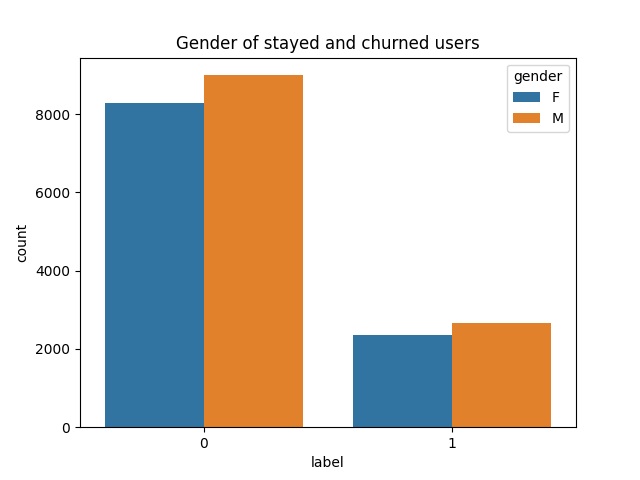

In [98]:
plt.figure()
plt.title('Gender of stayed and churned users')
sb.barplot(x = 'label', y = 'count',data = gender_pd, hue = 'gender')
plt.show()
%matplot plt

In [99]:
# Plotting a bar plot to show level distribution between stayed and churned users
level_pd = df_clean.drop_duplicates(['userId', 'level']).groupby(['label', 'level']).count().sort("label").toPandas()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

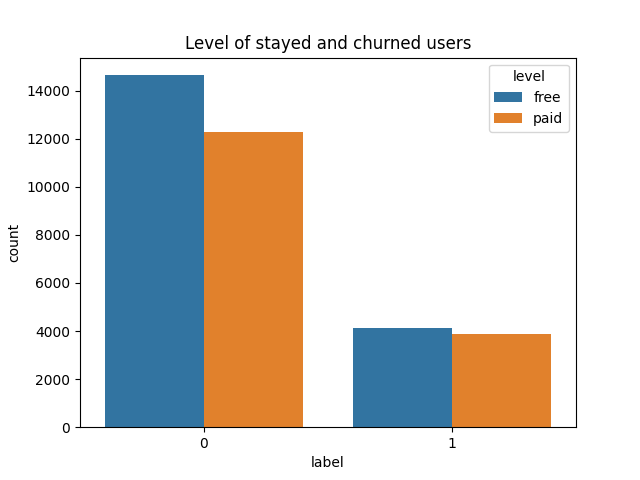

In [100]:
plt.figure()
plt.title('Level of stayed and churned users')
sb.barplot(x = 'label', y = 'count',data = level_pd, hue = 'level')
plt.show()
%matplot plt

In [101]:
# Plotting a bar plot to show downgrade condition between stayed and churned users
downgrade_pd = df_clean.drop_duplicates(['userId', 'downgraded']).groupby(['label', 'downgraded']).count().sort("label").toPandas()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

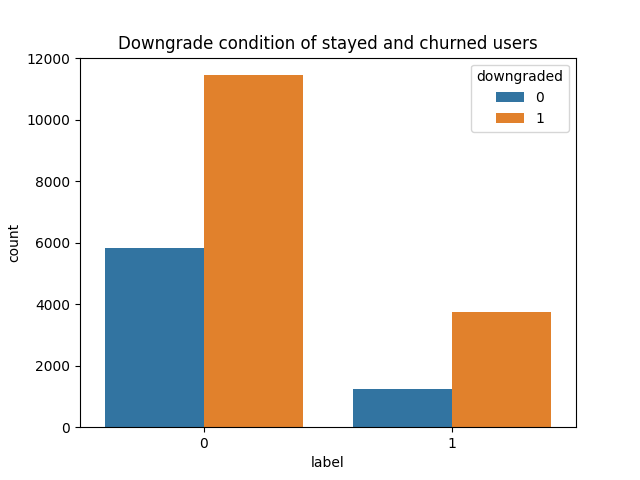

In [102]:
plt.figure()
plt.title('Downgrade condition of stayed and churned users')
sb.barplot(x = 'label', y = 'count',data = downgrade_pd, hue = 'downgraded')
plt.show()
%matplot plt

### Registered days


In [103]:
cancellation_df = df_clean.groupBy('userId').agg(max('ts').alias('lastinteraction'))
df_clean = cancellation_df.join(df_clean, on='userId').withColumn('registered_days', ((col('lastinteraction')-col('registration'))/86400000).cast(IntegerType()))
df_clean = df_clean.drop('lastinteraction','registration')
df_clean.show(2)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+--------+---------+------+-------------+---------+-----+------+--------+---------+--------------+------+-------------+-----+-------------------+----------+-----+-------+-----+----------+---------------+
| userId|  artist|     auth|gender|itemInSession|   length|level|method|    page|sessionId|          song|status|           ts|state|         epoch_time|      date|month|  agent|label|downgraded|registered_days|
+-------+--------+---------+------+-------------+---------+-----+------+--------+---------+--------------+------+-------------+-----+-------------------+----------+-----+-------+-----+----------+---------------+
|1001393| OutKast|Logged In|     M|            0|369.31873| paid|   PUT|NextSong|    23637|         Roses|   200|1541959714000|   OH|2018-11-11 18:08:34|2018-11-11|   11|Windows|    0|         1|             59|
|1001393|Maroon 5|Logged In|     M|            1|244.84526| paid|   PUT|NextSong|    23637|Sunday Morning|   200|1541960083000|   OH|2018-11-11 18:14:43

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

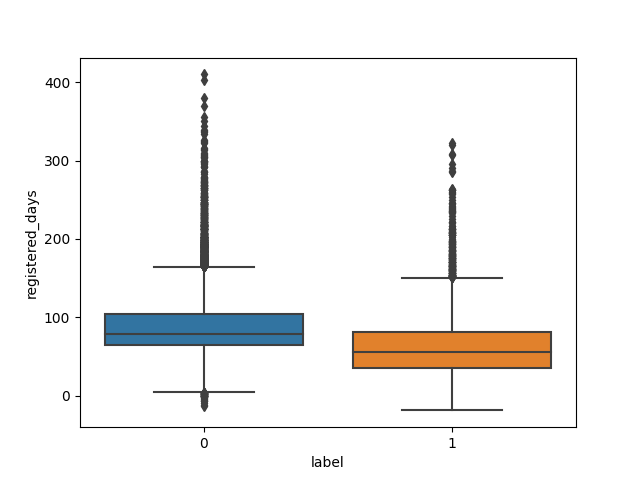

In [104]:
registered_days = df_clean.select(['userId','registered_days','label']).drop_duplicates(['userId']).sort("label").toPandas()
plt.figure()
sb.boxplot(y="registered_days", x="label", data=registered_days)
plt.show()
%matplot plt

### Latest "level" of users before they churn

In [105]:
level_df = df_clean.orderBy('ts', ascending=False).groupBy('userId').agg(first('level').alias('valid_level'))    
df_clean = df_clean.drop('level')
df_clean = df_clean.join(level_df, on='userId')
df_clean.show(2)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+-------------+---------+------+-------------+---------+------+--------+---------+--------------------+------+-------------+-----+-------------------+----------+-----+-------+-----+----------+---------------+-----------+
| userId|       artist|     auth|gender|itemInSession|   length|method|    page|sessionId|                song|status|           ts|state|         epoch_time|      date|month|  agent|label|downgraded|registered_days|valid_level|
+-------+-------------+---------+------+-------------+---------+------+--------+---------+--------------------+------+-------------+-----+-------------------+----------+-----+-------+-----+----------+---------------+-----------+
|1001393|Sheena Easton|Logged In|     M|            0|239.62077|   PUT|NextSong|    16255|Strut (1993 Digit...|   200|1540813195000|   OH|2018-10-29 11:39:55|2018-10-29|   10|Windows|    0|         1|             59|       paid|
|1001393| Dennis Brown|Logged In|     M|            1|175.38567|   PUT|NextSong|    

In [106]:
# Plotting a bar plot to show level of stayed and churned users
level_pd = df_clean.drop_duplicates(['userId', 'valid_level']).groupby(['label', 'valid_level']).count().sort("label").toPandas()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

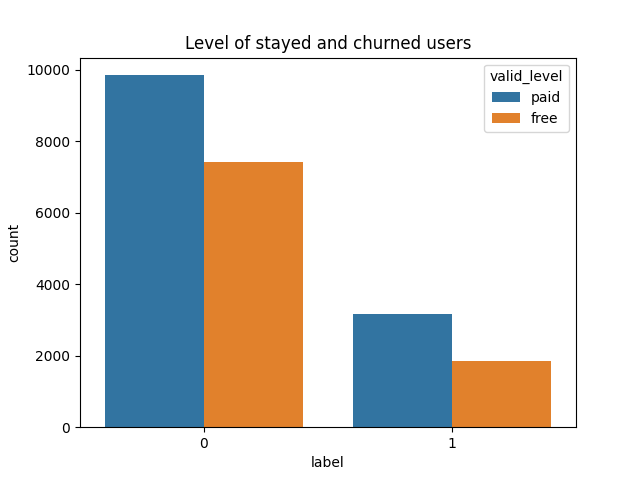

In [107]:
plt.figure()
plt.title('Level of stayed and churned users')
sb.barplot(x = 'label', y = 'count',data = level_pd, hue = 'valid_level')
plt.show()
%matplot plt

### Number of songs per day

In [108]:
temp_daily_song = df_clean.groupBy('userId','date').agg(countDistinct('song').alias('songs')).sort('userId')
daily_song = temp_daily_song.groupBy('userId').avg('songs').withColumnRenamed('avg(songs)', 'avg_daily_song')
df_clean = df_clean.join(daily_song, on='userId')
#df_clean = df_clean.drop('song')
df_clean.show(2)
avg_daily_song_pd = df_clean.select(['userId','avg_daily_song','label']).drop_duplicates(['userId']).sort("label").toPandas()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+------+---------+------+-------------+------+------+----------+---------+----+------+-------------+-----+-------------------+----------+-----+-------+-----+----------+---------------+-----------+--------------+
| userId|artist|     auth|gender|itemInSession|length|method|      page|sessionId|song|status|           ts|state|         epoch_time|      date|month|  agent|label|downgraded|registered_days|valid_level|avg_daily_song|
+-------+------+---------+------+-------------+------+------+----------+---------+----+------+-------------+-----+-------------------+----------+-----+-------+-----+----------+---------------+-----------+--------------+
|1001393|  null|Logged In|     M|            0|  null|   GET|      Home|     4382|null|   200|1539061413000|   OH|2018-10-09 05:03:33|2018-10-09|   10|Windows|    0|         1|             59|       paid|          61.5|
|1001393|  null|Logged In|     M|            1|  null|   PUT|Add Friend|     4382|null|   307|1539061414000|   OH|2018-1

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

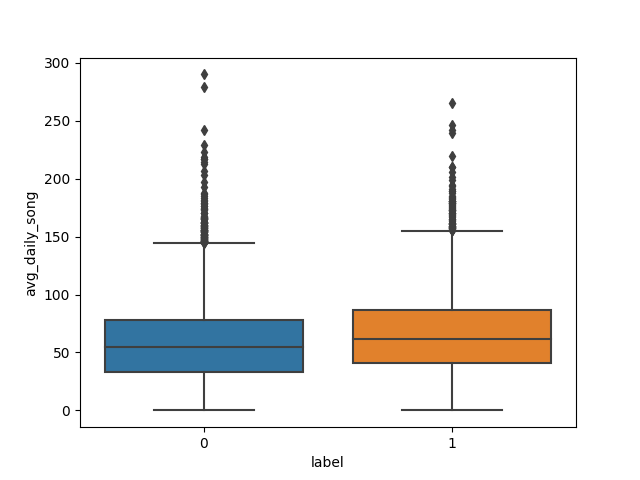

In [109]:
plt.figure()
sb.boxplot(y="avg_daily_song", x="label", data=avg_daily_song_pd)
plt.show()
%matplot plt

### Daily average item per session

In [110]:
daily_item_df = df_clean.groupby('userId','date').agg(max('itemInSession')).\
groupBy('userId').avg('max(itemInSession)').\
withColumnRenamed('avg(max(itemInSession))', 'avg_daily_items')
df_clean = df_clean.join(daily_item_df, on='userId')
df_clean = df_clean.drop('itemInSession')
df_clean.show(2)
avg_daily_items_pd = df_clean.select(['userId','avg_daily_items','label']).drop_duplicates(['userId']).sort("label").toPandas()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+-----------------+---------+------+---------+------+--------+---------+--------------------+------+-------------+-----+-------------------+----------+-----+-------+-----+----------+---------------+-----------+--------------+---------------+
| userId|           artist|     auth|gender|   length|method|    page|sessionId|                song|status|           ts|state|         epoch_time|      date|month|  agent|label|downgraded|registered_days|valid_level|avg_daily_song|avg_daily_items|
+-------+-----------------+---------+------+---------+------+--------+---------+--------------------+------+-------------+-----+-------------------+----------+-----+-------+-----+----------+---------------+-----------+--------------+---------------+
|1001393|             null|Logged In|     M|     null|   GET|    Home|     3445|                null|   200|1538365753000|   OH|2018-10-01 03:49:13|2018-10-01|   10|Windows|    0|         1|             59|       paid|          61.5|         95.875|


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

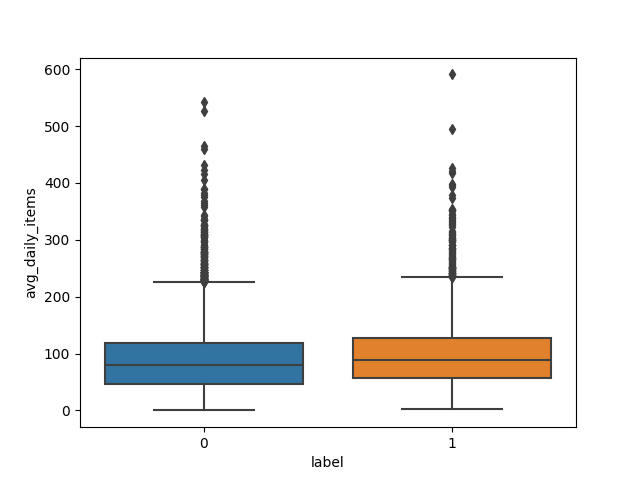

In [111]:
plt.figure()
sb.boxplot(y="avg_daily_items", x="label", data=avg_daily_items_pd)
plt.show()
%matplot plt

### Average session duration

In [112]:
session_duration = df_clean.groupBy('userId','sessionId').agg(((max('ts')-min('ts'))/86400000).alias('activesession'))
session_duration_df = session_duration.groupBy('userId').avg('activesession').withColumnRenamed('avg(activesession)', 'avg_session')
df_clean = df_clean.join(session_duration_df, on='userId')
df_clean = df_clean.drop('sessionId')
df_clean.show(2)
avg_session_pd = df_clean.select(['userId','avg_session','label']).drop_duplicates(['userId']).sort("label").toPandas()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Exception in thread cell_monitor-111:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/opt/conda/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.7/site-packages/awseditorssparkmonitoringwidget-1.0-py3.7.egg/awseditorssparkmonitoringwidget/cellmonitor.py", line 178, in cell_monitor
    job_binned_stages[job_id][stage_id] = all_stages[stage_id]
KeyError: 3396



+-------+-----------------+---------+------+---------+------+--------+--------------------+------+-------------+-----+-------------------+----------+-----+-------+-----+----------+---------------+-----------+--------------+---------------+-------------------+
| userId|           artist|     auth|gender|   length|method|    page|                song|status|           ts|state|         epoch_time|      date|month|  agent|label|downgraded|registered_days|valid_level|avg_daily_song|avg_daily_items|        avg_session|
+-------+-----------------+---------+------+---------+------+--------+--------------------+------+-------------+-----+-------------------+----------+-----+-------+-----+----------+---------------+-----------+--------------+---------------+-------------------+
|1001393|             null|Logged In|     M|     null|   GET|    Home|                null|   200|1538365753000|   OH|2018-10-01 03:49:13|2018-10-01|   10|Windows|    0|         1|             59|       paid|          61

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

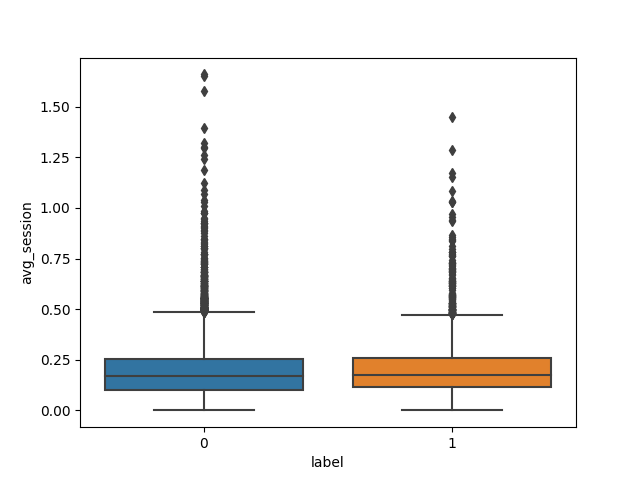

In [113]:
plt.figure()
sb.boxplot(y="avg_session", x="label", data=avg_session_pd)
plt.show()
%matplot plt

### Agent used by stayed and churned users

In [114]:
device_pd = df_clean.groupBy("agent", "label").agg(countDistinct("UserId").alias("users")).sort(col("users").desc()).toPandas()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Exception in thread cell_monitor-113:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/opt/conda/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.7/site-packages/awseditorssparkmonitoringwidget-1.0-py3.7.egg/awseditorssparkmonitoringwidget/cellmonitor.py", line 178, in cell_monitor
    job_binned_stages[job_id][stage_id] = all_stages[stage_id]
KeyError: 3482



VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

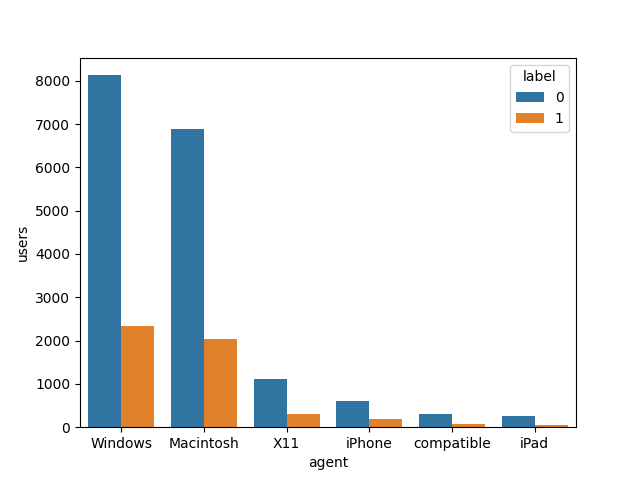

In [115]:
plt.figure()
sb.barplot(x="agent", y="users", hue="label", data=device_pd)
plt.show()
%matplot plt

### State of stayed and churned users

In [116]:
state_pd = df_clean.groupBy("state", "label").agg(countDistinct("UserId").alias("users")).sort(col("users").desc()).toPandas()
#sb.barplot(x="state", y="users", hue="label", data=state_pd)
#sb.set(rc={'figure.figsize':(11.7,8.27)})

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

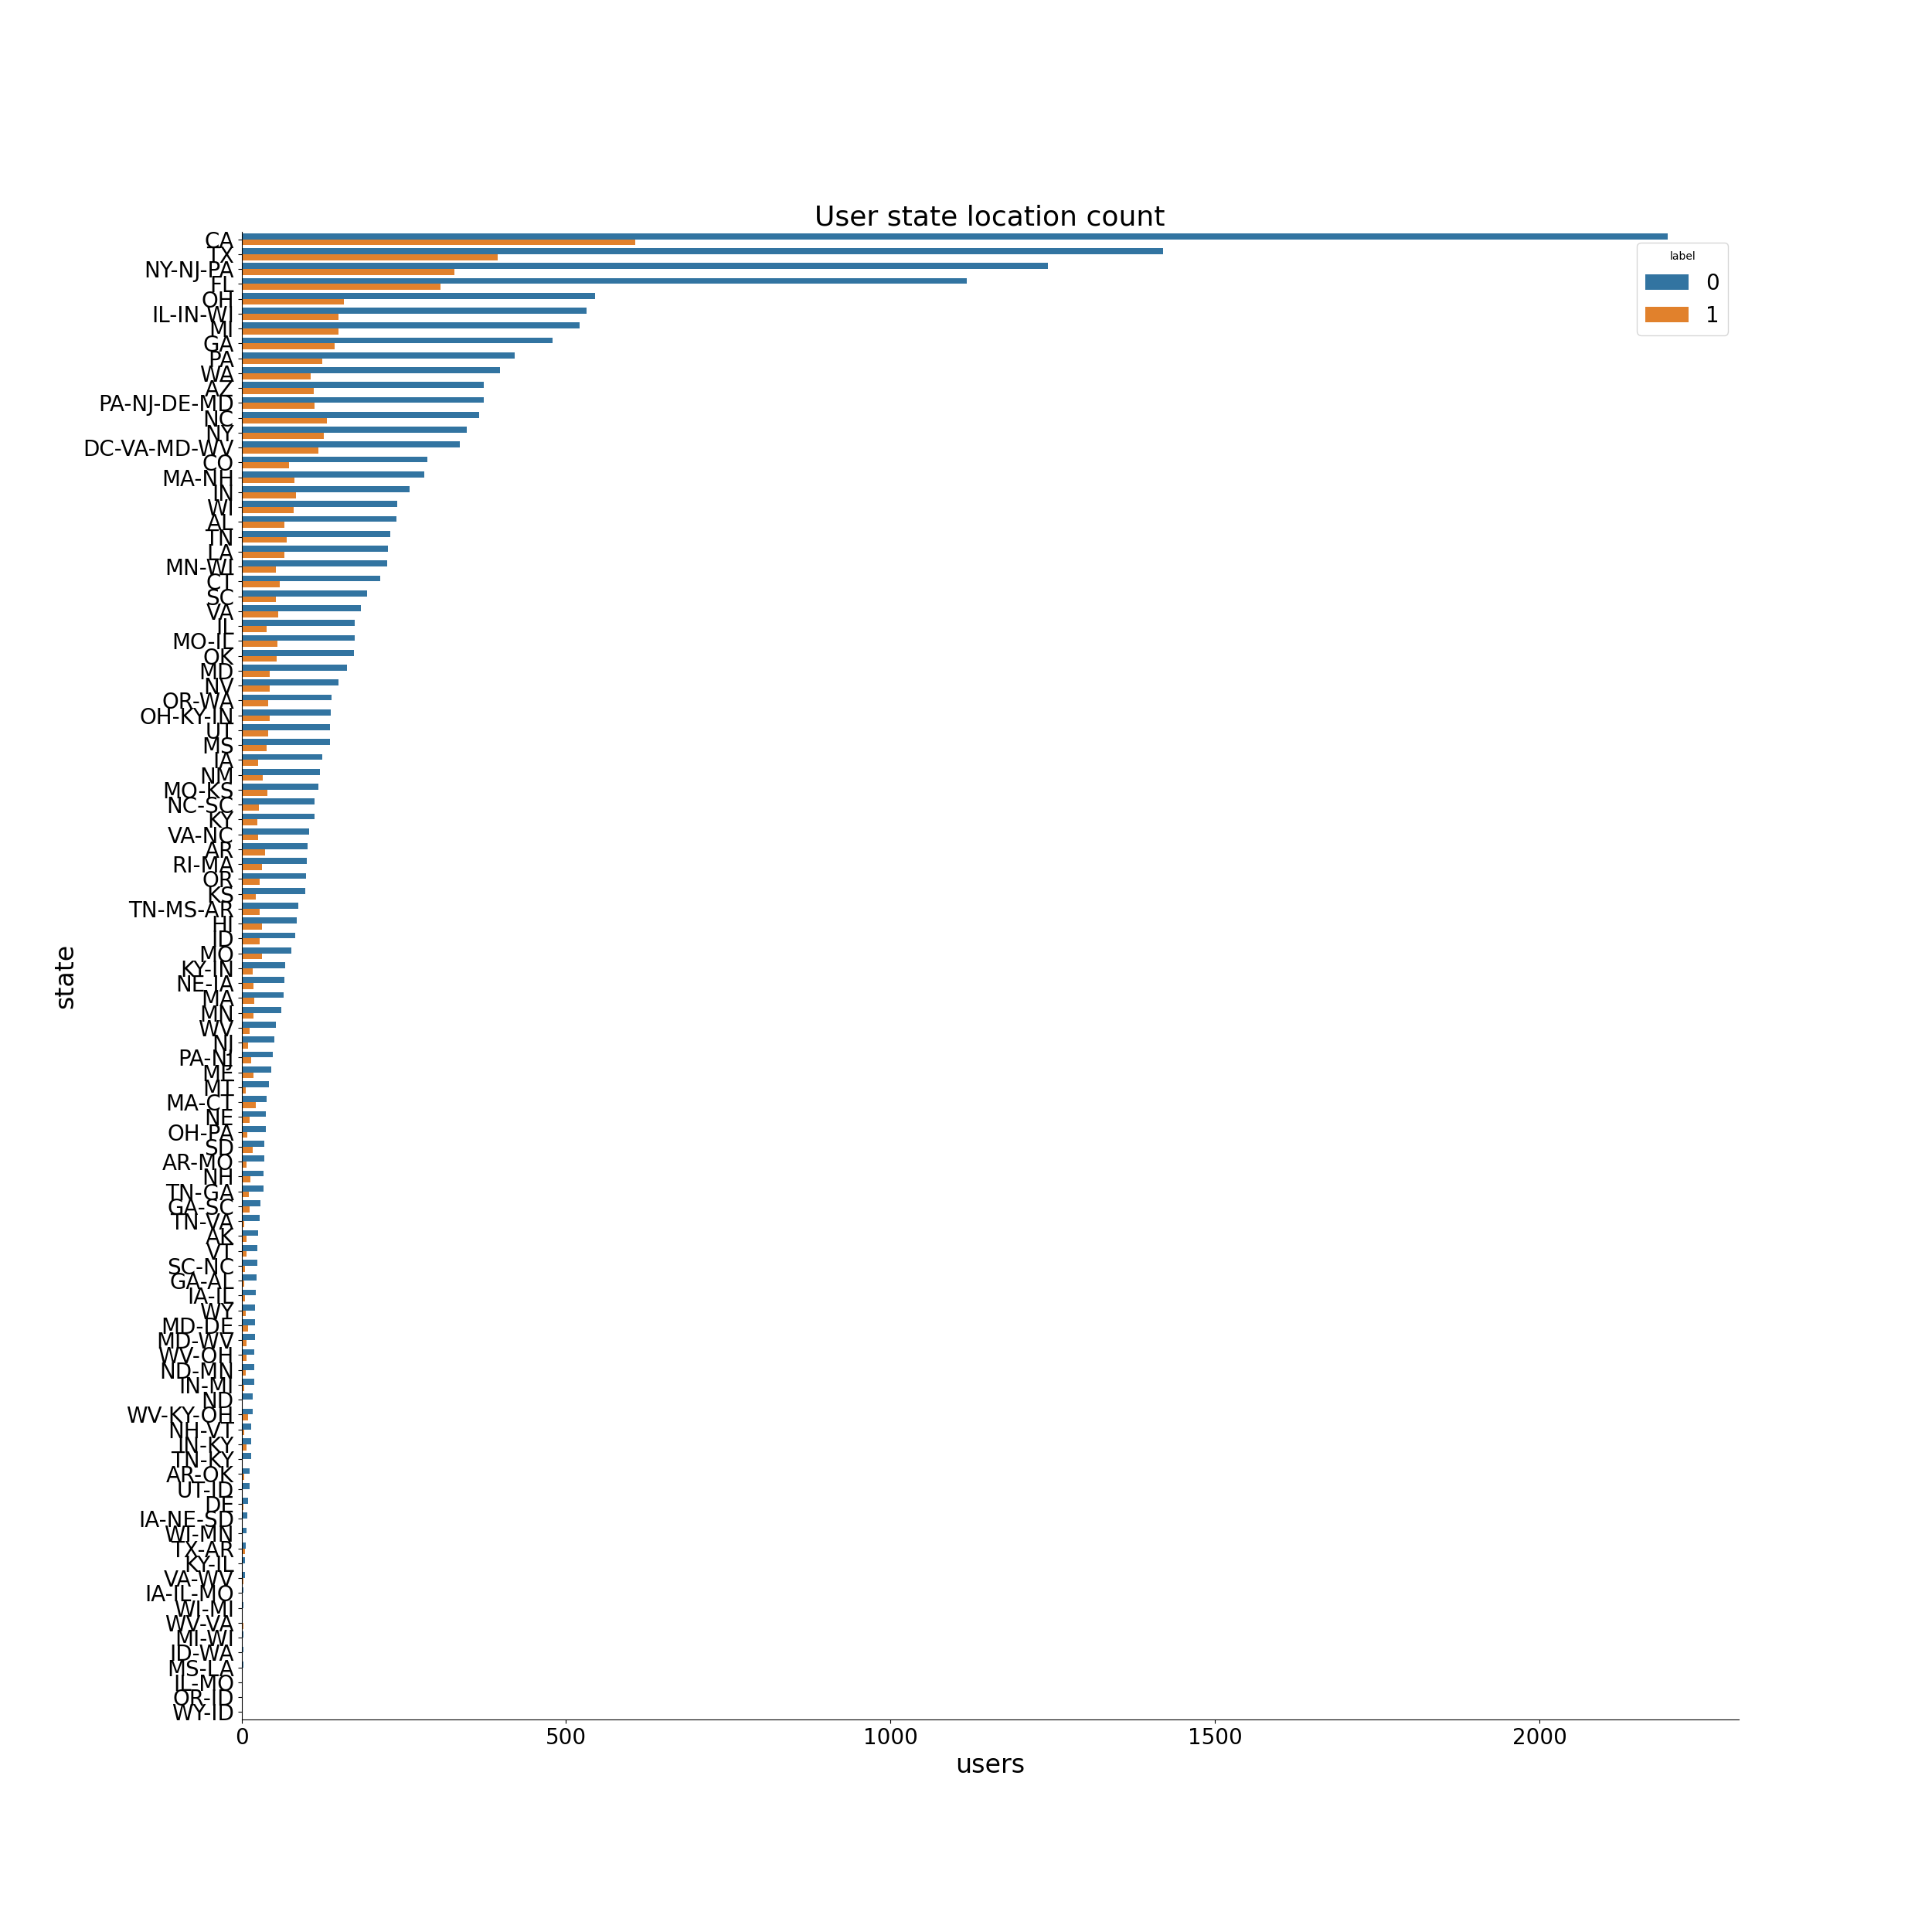

In [117]:
plt.figure(figsize=(25,25))
ax = sb.barplot(y="state", x="users", hue="label", data=state_pd)
plt.xlabel('users',fontsize=24)
plt.ylabel('state',fontsize=24)
plt.legend(title='label', loc='best',fontsize=20)
plt.title('User state location count',fontsize=26)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
sb.despine(ax=ax)
plt.show()
%matplot plt

## Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In [118]:
df_clean.columns

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

['userId', 'artist', 'auth', 'gender', 'length', 'method', 'page', 'song', 'status', 'ts', 'state', 'epoch_time', 'date', 'month', 'agent', 'label', 'downgraded', 'registered_days', 'valid_level', 'avg_daily_song', 'avg_daily_items', 'avg_session']

In [119]:
df_model = df_clean.select(['userId','label','downgraded','gender','valid_level','agent','state','registered_days','avg_daily_items','avg_session','avg_daily_song']).dropDuplicates(['userId'])

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [120]:
df_model.show(10,False)
df_model.columns

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Exception in thread cell_monitor-115:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/opt/conda/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.7/site-packages/awseditorssparkmonitoringwidget-1.0-py3.7.egg/awseditorssparkmonitoringwidget/cellmonitor.py", line 178, in cell_monitor
    job_binned_stages[job_id][stage_id] = all_stages[stage_id]
KeyError: 3583



+-------+-----+----------+------+-----------+---------+-----+---------------+------------------+-------------------+------------------+
|userId |label|downgraded|gender|valid_level|agent    |state|registered_days|avg_daily_items   |avg_session        |avg_daily_song    |
+-------+-----+----------+------+-----------+---------+-----+---------------+------------------+-------------------+------------------+
|1001393|0    |1         |M     |paid       |Windows  |OH   |59             |95.875            |0.21680224867724868|61.5              |
|1004316|0    |1         |M     |paid       |Windows  |CA   |59             |86.86666666666666 |0.19163734567901233|65.2              |
|1008404|1    |1         |F     |paid       |Macintosh|FL   |111            |162.1891891891892 |0.27197680898491083|132.35135135135135|
|1010669|0    |1         |M     |paid       |Macintosh|PA   |108            |162.6153846153846 |0.3761651234567901 |98.38461538461539 |
|1011149|0    |1         |M     |paid       |Mac

In [121]:
df_model.count()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Exception in thread cell_monitor-120:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/opt/conda/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.7/site-packages/awseditorssparkmonitoringwidget-1.0-py3.7.egg/awseditorssparkmonitoringwidget/cellmonitor.py", line 178, in cell_monitor
    job_binned_stages[job_id][stage_id] = all_stages[stage_id]
KeyError: 3696



22277

### Transform categorical columns with StringIndexer

In [122]:
indexers = [StringIndexer(inputCol=column, outputCol=column+"_index").fit(df_model) for column in ['gender','valid_level','agent','state'] ]
pipeline = Pipeline(stages=indexers)
df_r = pipeline.fit(df_model).transform(df_model)
df_model = df_r.drop('gender','valid_level','agent','state','userId')
df_model.show(1)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----+----------+---------------+---------------+------------------+--------------+------------+-----------------+-----------+-----------+
|label|downgraded|registered_days|avg_daily_items|       avg_session|avg_daily_song|gender_index|valid_level_index|agent_index|state_index|
+-----+----------+---------------+---------------+------------------+--------------+------------+-----------------+-----------+-----------+
|    0|         1|             59|         95.875|0.2168022486772487|          61.5|         0.0|              0.0|        0.0|        4.0|
+-----+----------+---------------+---------------+------------------+--------------+------------+-----------------+-----------+-----------+
only showing top 1 row

Exception in thread cell_monitor-139:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/opt/conda/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.7/site-packages/awseditorssparkmonitoringwidget-1.0-py3.7.egg/awseditorssparkmonitoringwidget/cellmonitor.py", line 178, in cell_monitor
    job_binned_stages[job_id][stage_id] = all_stages[stage_id]
KeyError: 6687



### Standard sclarizer
Use StandardScaler to scalerize the created “scaled_feature” column

In [123]:
# assembeling numeric features to create a vector
cols=['registered_days','avg_daily_items','avg_session','avg_daily_song']
assembler = VectorAssembler(inputCols=cols,outputCol="features")

# use the transform method to transform df
df_model = assembler.transform(df_model)
df_model.select("features").show(truncate=False)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----------------------------------------------------------------+
|features                                                        |
+----------------------------------------------------------------+
|[59.0,95.875,0.21680224867724865,61.5]                          |
|[58.0,155.5,0.31459490740740736,107.42307692307692]             |
|[59.0,86.86666666666666,0.1916373456790123,65.2]                |
|[61.0,161.5,0.5334548611111112,117.0]                           |
|[111.0,162.1891891891892,0.27197680898491083,132.35135135135135]|
|[108.0,162.6153846153846,0.37616512345679015,98.38461538461539] |
|[64.0,114.11111111111111,0.2274754050925926,64.5]               |
|[76.0,80.66666666666667,0.18722453703703704,54.75]              |
|[19.0,36.25,0.06375868055555556,22.5]                           |
|[61.0,157.77777777777777,0.3818402777777778,101.0]              |
|[130.0,81.33333333333333,0.15029265873015873,41.44444444444444] |
|[62.0,104.36363636363636,0.17665930134680133,61.8181818181818

In [124]:
# standardize numeric feature vector
standardscaler=StandardScaler().setInputCol("features").setOutputCol("Scaled_features")
df_model = standardscaler.fit(df_model).transform(df_model)
df_model.select("Scaled_features").show(2,False)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----------------------------------------------------------------------------+
|Scaled_features                                                              |
+-----------------------------------------------------------------------------+
|[1.4432028550033484,1.8153048912585479,1.7605856980437384,1.9553180852305552]|
|[1.4187417896643086,2.944249393384138,2.5547303961935297,3.4153867492488685] |
+-----------------------------------------------------------------------------+
only showing top 2 rows

### Combine all features in one single feature vector

In [125]:
df_model.columns

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

['label', 'downgraded', 'registered_days', 'avg_daily_items', 'avg_session', 'avg_daily_song', 'gender_index', 'valid_level_index', 'agent_index', 'state_index', 'features', 'Scaled_features']

In [126]:
cols=['Scaled_features','downgraded','gender_index','valid_level_index','agent_index','state_index']
assembler = VectorAssembler(inputCols=cols,outputCol='exp_features')
# use the transform method to transform df
df_model = assembler.transform(df_model)
df_model.select('exp_features').show(n=3,truncate=False)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------------------------------------------------------------------------------------------------+
|exp_features                                                                                     |
+-------------------------------------------------------------------------------------------------+
|[1.4432028550033484,1.8153048912585479,1.7605856980437384,1.9553180852305552,1.0,0.0,0.0,0.0,4.0]|
|[1.4432028550033484,1.64474038995907,1.5562291077331407,2.072955108244426,1.0,0.0,0.0,0.0,0.0]   |
|[2.715178252633418,3.0709030346220927,2.208641667786619,4.207951071577249,1.0,1.0,0.0,1.0,3.0]   |
+-------------------------------------------------------------------------------------------------+
only showing top 3 rows

## Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

### Train test split
As a first step break your data set into 80% of training data and set aside 20%. Set random seed to `42`.

In [127]:
rest, validation = df_model.randomSplit([0.8, 0.2], seed=42)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

### Check imbalance in the dataset

In [128]:
dataset_size = float(rest.select('label').count())
numPositives = rest.select('label').where('label == 1').count()
per_ones = (float(numPositives)/float(dataset_size))*100
numNegatives = float(dataset_size-numPositives)
print('The number of ones are {}'.format(numPositives))
print('Percentage of ones are {}'.format(per_ones))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

The number of ones are 4013
Percentage of ones are 22.485571804785117

### Class weighing

In [129]:
BalancingRatio= numNegatives/dataset_size
print('BalancingRatio = {}'.format(BalancingRatio))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

BalancingRatio = 0.7751442819521488

In [130]:
# creating a new column named “classWeights” in the “rest” dataset
rest = rest.withColumn("classWeights", when(rest.label == 1,BalancingRatio).otherwise(1-BalancingRatio))
rest.select("classWeights").show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+------------------+
|      classWeights|
+------------------+
|0.2248557180478512|
|0.2248557180478512|
|0.2248557180478512|
|0.2248557180478512|
|0.2248557180478512|
+------------------+
only showing top 5 rows

### Logistic regression model

In [131]:
lr = LogisticRegression(labelCol="label", featuresCol="exp_features",weightCol="classWeights",maxIter=10)
model = lr.fit(rest)
predict_rest = model.transform(rest)
predict_val = model.transform(validation)
predict_val.select("label","prediction").show(10)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Exception in thread cell_monitor-130:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/opt/conda/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.7/site-packages/awseditorssparkmonitoringwidget-1.0-py3.7.egg/awseditorssparkmonitoringwidget/cellmonitor.py", line 178, in cell_monitor
    job_binned_stages[job_id][stage_id] = all_stages[stage_id]
KeyError: 4683



+-----+----------+
|label|prediction|
+-----+----------+
|    0|       1.0|
|    0|       0.0|
|    0|       1.0|
|    0|       0.0|
|    0|       0.0|
|    0|       0.0|
|    0|       0.0|
|    0|       0.0|
|    0|       0.0|
|    0|       0.0|
+-----+----------+
only showing top 10 rows

In [132]:
# Evaluating the LR model using BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction",labelCol="label")
predict_val.select("label","rawPrediction","prediction","probability").show(5)
#print("The area under ROC for train set is {}".format(evaluator.evaluate(predict_rest)))
#print("The area under ROC for test set is {}".format(evaluator.evaluate(predict_val)))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----+--------------------+----------+--------------------+
|label|       rawPrediction|prediction|         probability|
+-----+--------------------+----------+--------------------+
|    0|[-0.8467848306177...|       1.0|[0.30010774730474...|
|    0|[0.04014060839957...|       0.0|[0.51003380487331...|
|    0|[-0.0629861225313...|       1.0|[0.48425867317346...|
|    0|[0.38391148110004...|       0.0|[0.59481615713828...|
|    0|[0.07673638935555...|       0.0|[0.51917468912486...|
+-----+--------------------+----------+--------------------+
only showing top 5 rows

In [133]:
#F1 score
f1_score_evaluator = MulticlassClassificationEvaluator(metricName='f1')
f1_score_rest = f1_score_evaluator.evaluate(predict_rest.select(col('label'), col('prediction')))
f1_score_val = f1_score_evaluator.evaluate(predict_val.select(col('label'), col('prediction')))
print('The F1 score on the train set is {:.2%}'.format(f1_score_rest))
print('The F1 score on the test set is {:.2%}'.format(f1_score_val)) 

#area under ROC 
auc_evaluator = BinaryClassificationEvaluator()
roc_value_rest = auc_evaluator.evaluate(predict_rest, {auc_evaluator.metricName: "areaUnderROC"})
roc_value_val = auc_evaluator.evaluate(predict_val, {auc_evaluator.metricName: "areaUnderROC"})
print('The areaUnderROC on the train set is {:.2%}'.format(roc_value_rest))
print('The areaUnderROC on the test set is {:.2%}'.format(roc_value_val))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

The F1 score on the train set is 69.15%
The F1 score on the test set is 68.58%
The areaUnderROC on the train set is 73.46%
The areaUnderROC on the test set is 73.01%

### Random forest model

In [135]:
rf = RandomForestClassifier(labelCol="label", featuresCol="exp_features")#,maxIter=10)#weightCol="classWeights") 
model = rf.fit(rest)
predict_rest = model.transform(rest)
predict_val = model.transform(validation)
predict_val.select("label","prediction").show(10)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

'requirement failed: DecisionTree requires maxBins (= 32) to be at least as large as the number of values in each categorical feature, but categorical feature 8 has 100 values. Considering remove this and other categorical features with a large number of values, or add more training examples.'
Traceback (most recent call last):
  File "/usr/lib/spark/python/lib/pyspark.zip/pyspark/ml/base.py", line 132, in fit
    return self._fit(dataset)
  File "/usr/lib/spark/python/lib/pyspark.zip/pyspark/ml/wrapper.py", line 295, in _fit
    java_model = self._fit_java(dataset)
  File "/usr/lib/spark/python/lib/pyspark.zip/pyspark/ml/wrapper.py", line 292, in _fit_java
    return self._java_obj.fit(dataset._jdf)
  File "/usr/lib/spark/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/usr/lib/spark/python/lib/pyspark.zip/pyspark/sql/utils.py", line 79, in deco
    raise IllegalArgumentException(s.split('

In [136]:
# Evaluating the RF model using BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction",labelCol="label")
predict_val.select("label","rawPrediction","prediction","probability").show(5)

#F1 score
f1_score_evaluator = MulticlassClassificationEvaluator(metricName='f1')
f1_score_rest = f1_score_evaluator.evaluate(predict_rest.select(col('label'), col('prediction')))
f1_score_val = f1_score_evaluator.evaluate(predict_val.select(col('label'), col('prediction')))
print('The F1 score on the train set is {:.2%}'.format(f1_score_rest))
print('The F1 score on the test set is {:.2%}'.format(f1_score_val)) 

#area under ROC 
auc_evaluator = BinaryClassificationEvaluator()
roc_value_rest = auc_evaluator.evaluate(predict_rest, {auc_evaluator.metricName: "areaUnderROC"})
roc_value_val = auc_evaluator.evaluate(predict_val, {auc_evaluator.metricName: "areaUnderROC"})
print('The areaUnderROC on the train set is {:.2%}'.format(roc_value_rest))
print('The areaUnderROC on the test set is {:.2%}'.format(roc_value_val))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Exception in thread cell_monitor-135:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/opt/conda/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.7/site-packages/awseditorssparkmonitoringwidget-1.0-py3.7.egg/awseditorssparkmonitoringwidget/cellmonitor.py", line 178, in cell_monitor
    job_binned_stages[job_id][stage_id] = all_stages[stage_id]
KeyError: 5874



+-----+--------------------+----------+--------------------+
|label|       rawPrediction|prediction|         probability|
+-----+--------------------+----------+--------------------+
|    0|[-0.8467848306177...|       1.0|[0.30010774730474...|
|    0|[0.04014060839957...|       0.0|[0.51003380487331...|
|    0|[-0.0629861225313...|       1.0|[0.48425867317346...|
|    0|[0.38391148110004...|       0.0|[0.59481615713828...|
|    0|[0.07673638935555...|       0.0|[0.51917468912486...|
+-----+--------------------+----------+--------------------+
only showing top 5 rows

The F1 score on the train set is 69.14%
The F1 score on the test set is 68.64%
The areaUnderROC on the train set is 73.45%
The areaUnderROC on the test set is 73.01%

### Gradient boosted tree model

In [137]:
gbt = GBTClassifier(labelCol="label", featuresCol="exp_features", maxIter=10)
model = gbt.fit(rest)
predict_rest = model.transform(rest)
predict_val = model.transform(validation)
predict_val.select("label","prediction").show(10)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Exception in thread cell_monitor-136:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/opt/conda/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.7/site-packages/awseditorssparkmonitoringwidget-1.0-py3.7.egg/awseditorssparkmonitoringwidget/cellmonitor.py", line 178, in cell_monitor
    job_binned_stages[job_id][stage_id] = all_stages[stage_id]
KeyError: 6077

'requirement failed: DecisionTree requires maxBins (= 32) to be at least as large as the number of values in each categorical feature, but categorical feature 8 has 100 values. Considering remove this and other categorical features with a large number of values, or add more training examples.'
Traceback (most recent call last):
  File "/usr/lib/spark/python/lib/pyspark.zip/pyspark/ml/base.py", line 132, in fit
    return self._fit(dataset)
  File "/usr/lib/spark/python/li

In [138]:
# Evaluating the RF model using BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction",labelCol="label")
predict_val.select("label","rawPrediction","prediction","probability").show(5)

#F1 score
f1_score_evaluator = MulticlassClassificationEvaluator(metricName='f1')
f1_score_rest = f1_score_evaluator.evaluate(predict_rest.select(col('label'), col('prediction')))
f1_score_val = f1_score_evaluator.evaluate(predict_val.select(col('label'), col('prediction')))
print('The F1 score on the train set is {:.2%}'.format(f1_score_rest))
print('The F1 score on the test set is {:.2%}'.format(f1_score_val)) 

#area under ROC 
auc_evaluator = BinaryClassificationEvaluator()
roc_value_rest = auc_evaluator.evaluate(predict_rest, {auc_evaluator.metricName: "areaUnderROC"})
roc_value_val = auc_evaluator.evaluate(predict_val, {auc_evaluator.metricName: "areaUnderROC"})
print('The areaUnderROC on the train set is {:.2%}'.format(roc_value_rest))
print('The areaUnderROC on the test set is {:.2%}'.format(roc_value_val))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Exception in thread cell_monitor-137:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/opt/conda/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.7/site-packages/awseditorssparkmonitoringwidget-1.0-py3.7.egg/awseditorssparkmonitoringwidget/cellmonitor.py", line 178, in cell_monitor
    job_binned_stages[job_id][stage_id] = all_stages[stage_id]
KeyError: 6382



+-----+--------------------+----------+--------------------+
|label|       rawPrediction|prediction|         probability|
+-----+--------------------+----------+--------------------+
|    0|[-0.8467848306177...|       1.0|[0.30010774730474...|
|    0|[0.04014060839957...|       0.0|[0.51003380487331...|
|    0|[-0.0629861225313...|       1.0|[0.48425867317346...|
|    0|[0.38391148110004...|       0.0|[0.59481615713828...|
|    0|[0.07673638935555...|       0.0|[0.51917468912486...|
+-----+--------------------+----------+--------------------+
only showing top 5 rows

The F1 score on the train set is 69.16%
The F1 score on the test set is 68.64%
The areaUnderROC on the train set is 73.45%
The areaUnderROC on the test set is 73.01%

### Hyperparameter tuning for random forest model

In [139]:
paramGrid = ParamGridBuilder()\
    .addGrid(rf.maxDepth,[5,10,15])\
    .addGrid(rf.numTrees, [20,50,75,100])\
    .addGrid(rf.impurity,["entropy", "gini"])\
    .build()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [140]:
# K-fold cross validation
# Create 5-fold CrossValidator
cv = CrossValidator(estimator=rf, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=3)
# Run cross validations
cvModel = cv.fit(rest)
# this will likely take a fair amount of time because of the amount of models that we're creating and testing
predict_rest = cvModel.transform(rest)
predict_validation = cvModel.transform(validation)
print("The area under ROC for train set after CV  is {}".format(evaluator.evaluate(predict_rest)))
print("The area under ROC for test set after CV  is {}".format(evaluator.evaluate(predict_validation)))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

'requirement failed: DecisionTree requires maxBins (= 32) to be at least as large as the number of values in each categorical feature, but categorical feature 8 has 100 values. Considering remove this and other categorical features with a large number of values, or add more training examples.'
Traceback (most recent call last):
  File "/usr/lib/spark/python/lib/pyspark.zip/pyspark/ml/base.py", line 132, in fit
    return self._fit(dataset)
  File "/usr/lib/spark/python/lib/pyspark.zip/pyspark/ml/tuning.py", line 304, in _fit
    for j, metric, subModel in pool.imap_unordered(lambda f: f(), tasks):
  File "/usr/lib64/python3.7/multiprocessing/pool.py", line 748, in next
    raise value
  File "/usr/lib64/python3.7/multiprocessing/pool.py", line 121, in worker
    result = (True, func(*args, **kwds))
  File "/usr/lib/spark/python/lib/pyspark.zip/pyspark/ml/tuning.py", line 304, in <lambda>
    for j, metric, subModel in pool.imap_unordered(lambda f: f(), tasks):
  File "/usr/lib/spark/py